In [19]:
# Importations
import pandas as pd
import numpy as np
import os
import shutil # Utilisé pour la suppression potentielle de dossiers non vides

# Bibliothèques pour le Machine Learning et la Préparation des Données
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Bibliothèques pour la Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D 
from scipy.stats import iqr

# Définition de K_OPTIMAL (utilisé dans la Phase 6 et 9)
# K_OPTIMAL = 3 est conservé tel quel dans votre dernier code
K_OPTIMAL = 3

In [20]:
print("--- Début du Nettoyage des Données (Tâche 2) ---")

# 1. Chargement du fichier brut
df = pd.read_csv("network_traffic_raw.csv")
rows_before = len(df)

# 2. Correction des Valeurs Invalides/Négatives (Remplacer par NaN)
numeric_cols_to_check = ['FlowDuration', 'TotalPackets', 'TotalBytes', 'PacketRate']
for col in numeric_cols_to_check:
    df[col] = df[col].apply(lambda x: np.nan if x < 0 else x)

# 3. Standardisation de la colonne 'Protocol'
df['Protocol'] = df['Protocol'].str.strip().str.lower()
df['Protocol'] = df['Protocol'].replace({'t.c.p': 'tcp', 'u.d.p': 'udp'})

# 4. Suppression des lignes avec valeurs manquantes
# Utilisation de .copy() pour éviter SettingWithCopyWarning
df_clean = df.dropna().copy()
rows_after_drop = len(df_clean)
print(f"Lignes supprimées (NaN/Négatives) : {rows_before - rows_after_drop}")
print(f"Lignes conservées : {rows_after_drop}")

# 5. Traitement des Valeurs Aberrantes (Outliers) par Plafonnement (Capping IQR)
outlier_cols = ['FlowDuration', 'TotalPackets', 'TotalBytes', 'ByteRate', 'PacketRate']
for col in outlier_cols:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR_val = Q3 - Q1
    upper_bound = Q3 + 1.5 * IQR_val
    # Utilisation de .loc pour la modification sur la copie
    df_clean.loc[:, col] = np.where(df_clean[col] > upper_bound, upper_bound, df_clean[col])

# Sauvegarder le fichier nettoyé 
df_clean.to_csv("network_traffic_clean.csv", index=False)
print("Fichier 'network_traffic_clean.csv' créé (Nettoyage Tâche 2 terminé).")

--- Début du Nettoyage des Données (Tâche 2) ---
Lignes supprimées (NaN/Négatives) : 317
Lignes conservées : 1508
Fichier 'network_traffic_clean.csv' créé (Nettoyage Tâche 2 terminé).


In [21]:
print("--- Début de la Préparation K-Means (Tâche 4) ---")

# Recharger le fichier nettoyé (pour s'assurer de l'indépendance des cellules)
df_clean = pd.read_csv("network_traffic_clean.csv")

# 1. Sélection et Encodage des Caractéristiques
df_features = df_clean.drop(columns=['FlowID'])
df_encoded = pd.get_dummies(df_features, columns=['Protocol'], drop_first=False)
df_encoded = df_encoded.drop(columns=['Protocol_?', 'Protocol_unknown'], errors='ignore')

# 2. Mise à l'Échelle (Scaling) des Caractéristiques
scaler = StandardScaler()
df_scaled_data = scaler.fit_transform(df_encoded)
df_scaled = pd.DataFrame(df_scaled_data, columns=df_encoded.columns)

# 3. Vérification et Sauvegarde du fichier final
print(f"Nombre final de caractéristiques normalisées : {len(df_scaled.columns)}")
print("Vérification des statistiques (Moyenne ≈ 0, Écart-type ≈ 1) :")
print(df_scaled[['FlowDuration', 'TotalBytes', 'PacketRate']].describe().loc[['mean', 'std']].to_markdown(numalign="left", stralign="left", floatfmt=".2f"))

df_scaled.to_csv("network_traffic_scaled.csv", index=False)
print("\nFichier 'network_traffic_scaled.csv' créé (Préparation Tâche 4 terminée).")

--- Début de la Préparation K-Means (Tâche 4) ---
Nombre final de caractéristiques normalisées : 18
Vérification des statistiques (Moyenne ≈ 0, Écart-type ≈ 1) :
|      | FlowDuration   | TotalBytes   | PacketRate   |
|:-----|:---------------|:-------------|:-------------|
| mean | 0.00           | 0.00         | 0.00         |
| std  | 1.00           | 1.00         | 1.00         |

Fichier 'network_traffic_scaled.csv' créé (Préparation Tâche 4 terminée).


In [22]:
print("--- Début de la Tâche 5 : Détermination du K Optimal (Calcul WCSS) ---")

# 1. Chargement des données mises à l'échelle
df_scaled = pd.read_csv("network_traffic_scaled.csv")

# 2. Préparation du modèle et du conteneur WCSS
wcss = []
k_range = range(2, 11) # Tester K de 2 à 10

# 3. Calcul de la WCSS pour chaque K
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto') 
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# Affichage des scores
print("\nWCSS (Somme des Carrés Intra-Clusters) pour K = 2 à 10 :")
for k, score in zip(k_range, wcss):
    print(f"K={k}: {score:.2f}")

--- Début de la Tâche 5 : Détermination du K Optimal (Calcul WCSS) ---

WCSS (Somme des Carrés Intra-Clusters) pour K = 2 à 10 :
K=2: 20399.92
K=3: 16128.03
K=4: 14748.20
K=5: 13209.19
K=6: 9936.23
K=7: 9377.29
K=8: 8136.14
K=9: 7352.58
K=10: 6933.40


--- Visualisation Méthode du Coude ---


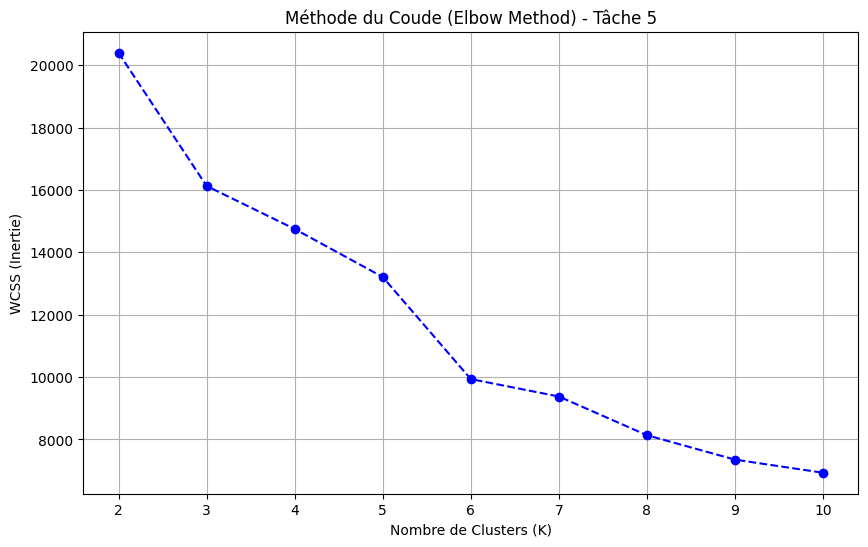

In [23]:
print("--- Visualisation Méthode du Coude ---")

# Nécessite wcss et k_range calculés dans la cellule précédente
plt.figure(figsize=(10, 6))
plt.plot(k_range, wcss, marker='o', linestyle='--', color='blue')
plt.title("Méthode du Coude (Elbow Method) - Tâche 5")
plt.xlabel("Nombre de Clusters (K)")
plt.ylabel("WCSS (Inertie)")
plt.xticks(k_range)
plt.grid(True)
plt.savefig("courbe_du_coude.png")
plt.show() # Affichage dans le notebook
plt.close()

In [24]:
print(f"--- Début de la Tâche 6 : K-Means avec K={K_OPTIMAL} ---")

# Chargement des données brutes propres et des données normalisées
df_clean = pd.read_csv("network_traffic_clean.csv")
df_scaled = pd.read_csv("network_traffic_scaled.csv")

# Application de K-Means
kmeans_final = KMeans(n_clusters=K_OPTIMAL, random_state=42, n_init='auto')
cluster_labels = kmeans_final.fit_predict(df_scaled)

# Attribuer les labels aux données non-mises à l'échelle
df_clean['Cluster'] = cluster_labels
df_clustered = df_clean.copy() 

# Sauvegarder le résultat du clustering
df_clean.to_csv("network_traffic_clustered.csv", index=False)
print(f"Clustering Terminé. Les étiquettes de cluster (0 à {K_OPTIMAL-1}) ont été ajoutées.")
print("Fichier 'network_traffic_clustered.csv' créé.")

--- Début de la Tâche 6 : K-Means avec K=3 ---
Clustering Terminé. Les étiquettes de cluster (0 à 2) ont été ajoutées.
Fichier 'network_traffic_clustered.csv' créé.


In [25]:
print("--- Début de la Tâche 8 : Profilage des Clusters ---")

# 1. Calcul des caractéristiques moyennes par cluster
cluster_summary = df_clustered.groupby('Cluster')[['FlowDuration', 'TotalPackets', 'TotalBytes', 
                                                   'PacketRate', 'ByteRate', 'Port', 
                                                   'AvgPacketSize', 'InterArrivalTime']].mean()

# Afficher les caractéristiques numériques moyennes
print("\n--- Statistiques Moyennes des Clusters (Profil Numérique) ---")
print(cluster_summary.to_markdown(numalign="left", stralign="left", floatfmt=".2f"))

# 2. Analyser les protocoles dominants
print("\n--- Protocoles Dominants par Cluster ---")
protocol_distribution = df_clustered.groupby('Cluster')['Protocol'].value_counts(normalize=True).mul(100).rename('Percent').reset_index()
dominant_protocols = protocol_distribution.loc[
    protocol_distribution.groupby('Cluster')['Percent'].idxmax()
]
print(dominant_protocols.to_markdown(numalign="left", stralign="left", floatfmt=".1f"))

--- Début de la Tâche 8 : Profilage des Clusters ---

--- Statistiques Moyennes des Clusters (Profil Numérique) ---
| Cluster   | FlowDuration   | TotalPackets   | TotalBytes   | PacketRate   | ByteRate   | Port     | AvgPacketSize   | InterArrivalTime   |
|:----------|:---------------|:---------------|:-------------|:-------------|:-----------|:---------|:----------------|:-------------------|
| 0         | 1249.32        | 35498.14       | 324821163.35 | 358.94       | 8087075.76 | 1406.49  | 1394.73         | 0.02               |
| 1         | 13.31          | 70.57          | 1026455.36   | 18.53        | 19971.44   | 1542.32  | 386.76          | 1.10               |
| 2         | 2747.91        | 94660.08       | 24513441.83  | 126.98       | 269234.15  | 34589.68 | 297.83          | 0.03               |

--- Protocoles Dominants par Cluster ---
|    | Cluster   | Protocol   | Percent   |
|:---|:----------|:-----------|:----------|
| 0  | 0         | tcp        | 99.7      |
| 3  

In [26]:
print("\n--- Début de la Tâche 7 : Évaluation des Clusters ---")

X = df_scaled  # données normalisées
labels = cluster_labels  # labels K-Means K=3

sil_score = silhouette_score(X, labels)
db_score = davies_bouldin_score(X, labels)
ch_score = calinski_harabasz_score(X, labels)

print(f"Silhouette Score : {sil_score:.4f}")
print(f"Davies-Bouldin Index : {db_score:.4f}")
print(f"Calinski-Harabasz Index : {ch_score:.4f}")


--- Début de la Tâche 7 : Évaluation des Clusters ---
Silhouette Score : 0.3402
Davies-Bouldin Index : 1.2324
Calinski-Harabasz Index : 513.9820



--- Visualisation Tâche 3 : EDA Combinée ---


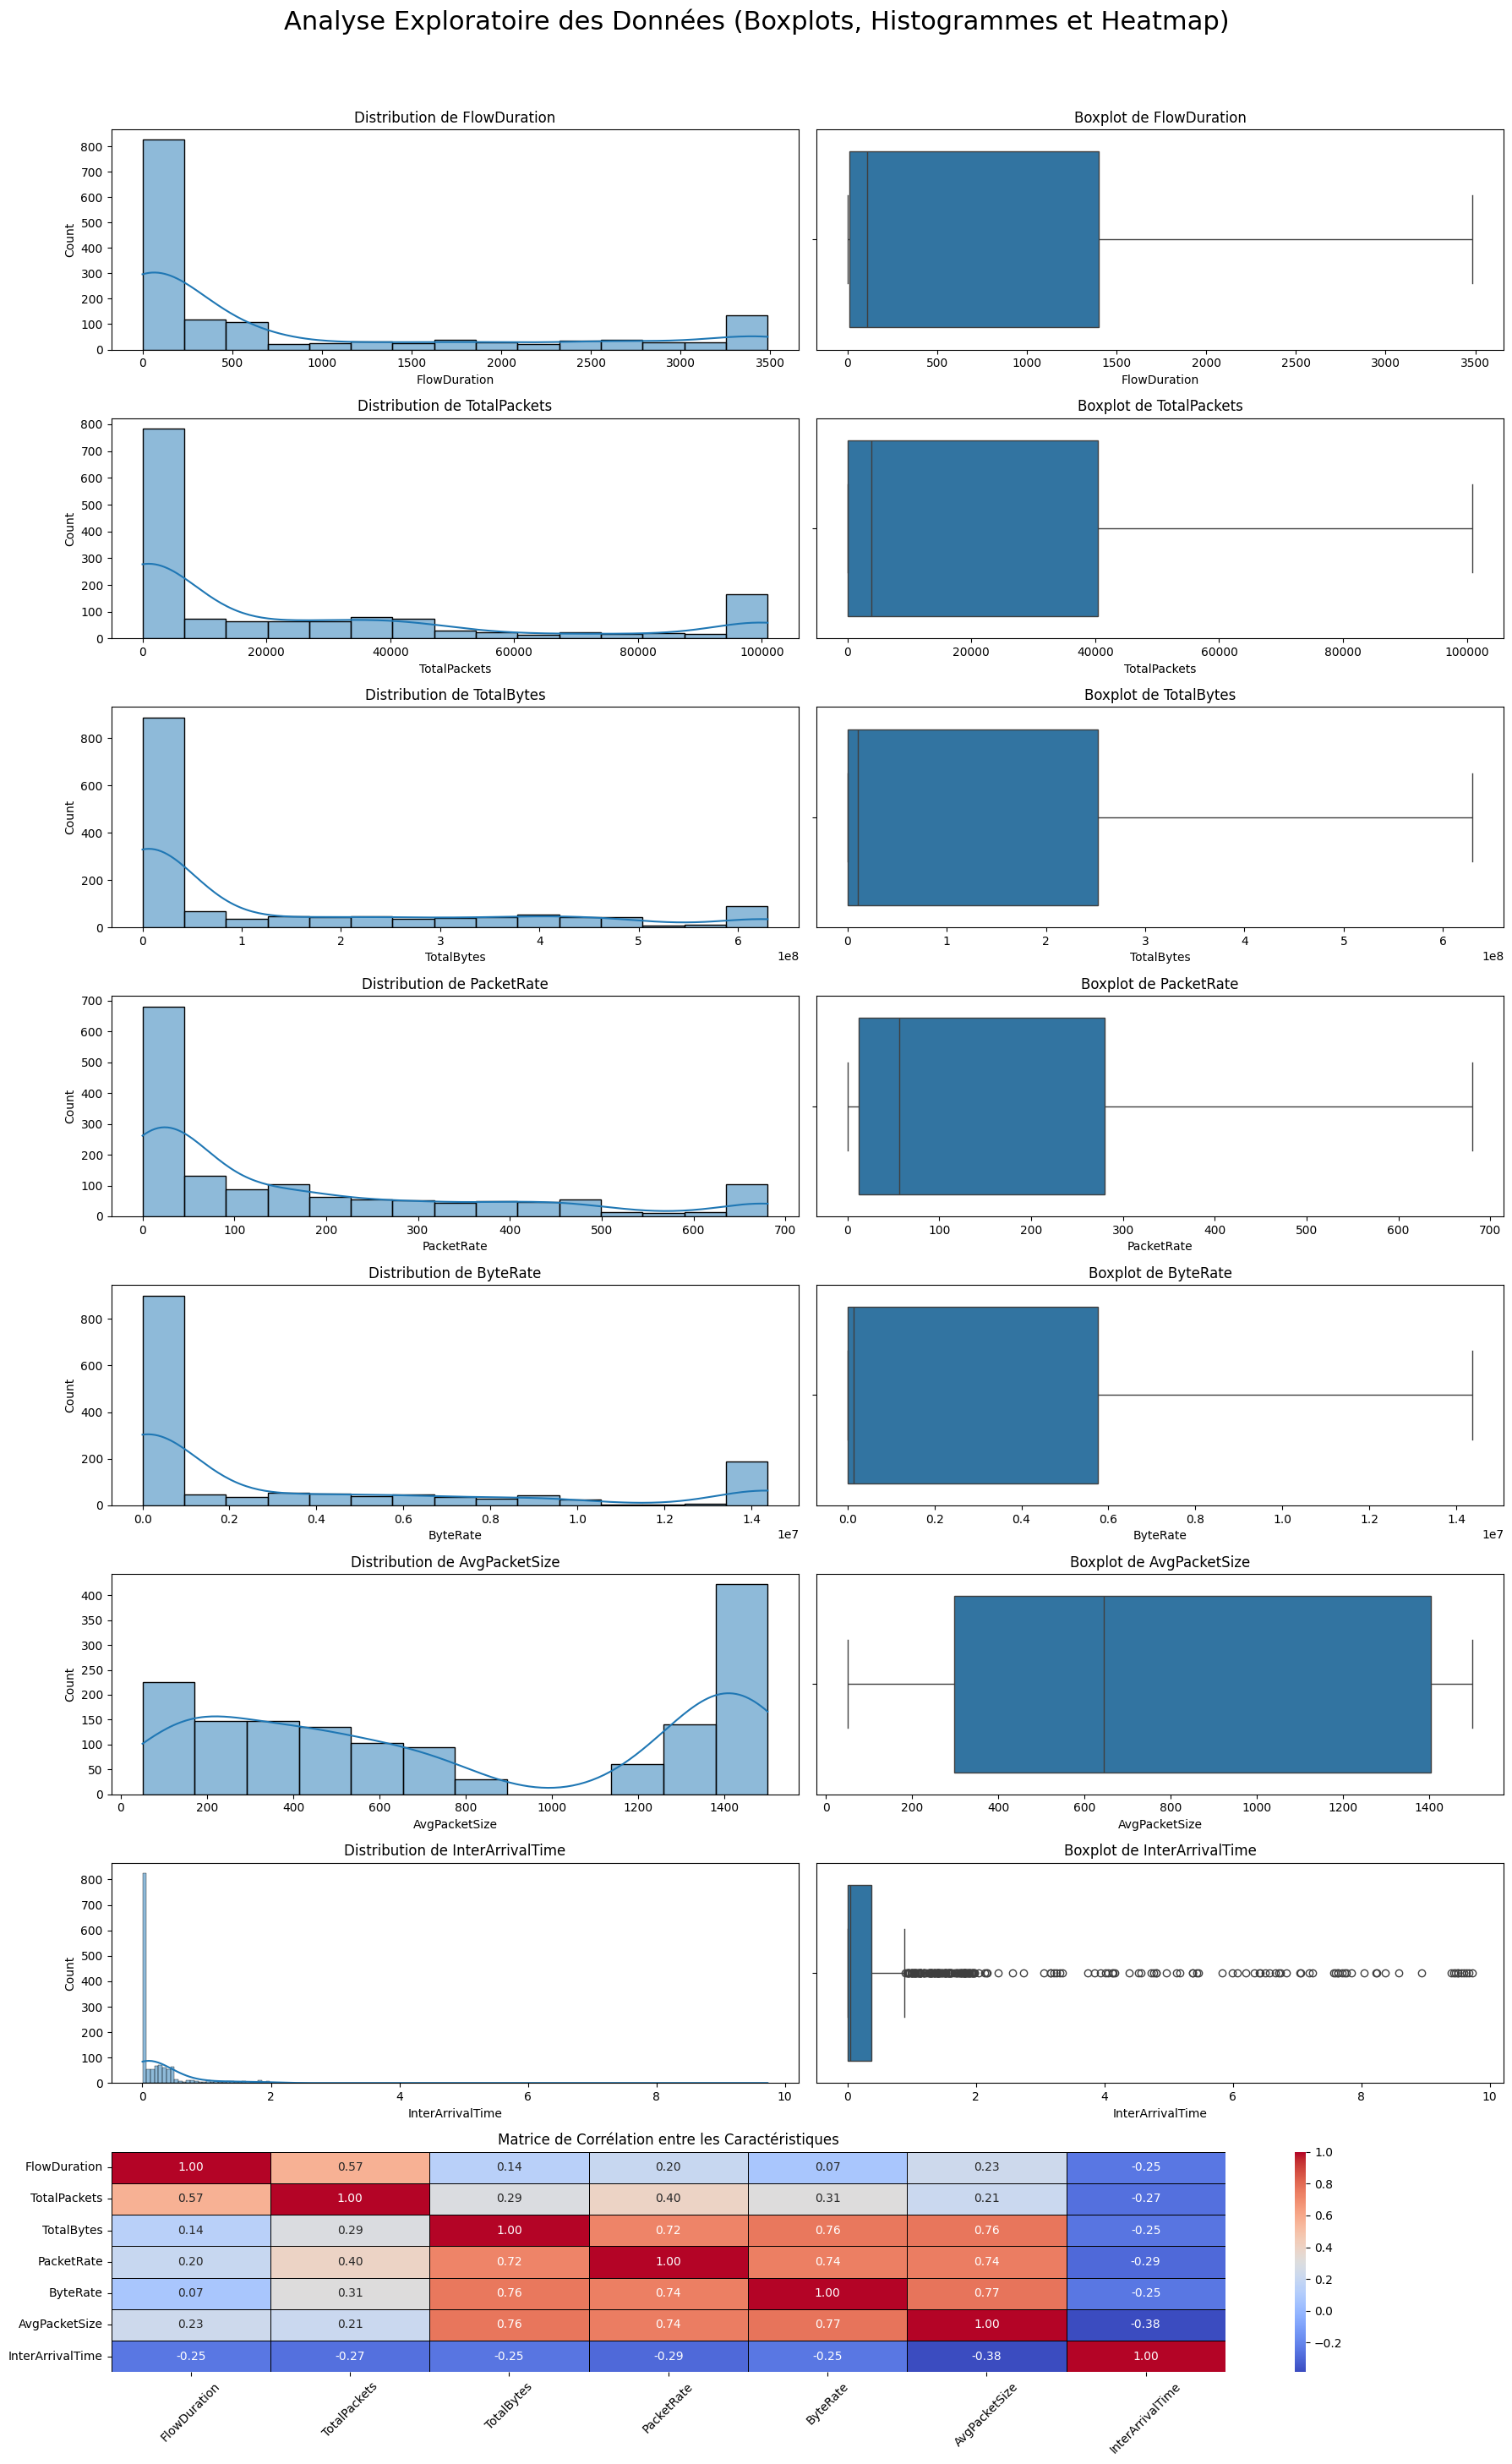

In [27]:
print("\n--- Visualisation Tâche 3 : EDA Combinée ---")

os.makedirs("plots_eda_all_combined", exist_ok=True) 

numeric_cols = [
    'FlowDuration', 'TotalPackets', 'TotalBytes',
    'PacketRate', 'ByteRate', 'AvgPacketSize', 'InterArrivalTime'
]
correlation_matrix = df_clean[numeric_cols].corr()

# Figure unique 8x2 (7 paires Hist/Box + 1 Heatmap)
fig, axs = plt.subplots(8, 2, figsize=(18, 30)) 
plt.suptitle("Analyse Exploratoire des Données (Boxplots, Histogrammes et Heatmap)", fontsize=22, y=1.00)

for i, col in enumerate(numeric_cols):
    row = i 
    sns.histplot(df_clean[col], kde=True, ax=axs[row, 0])
    axs[row, 0].set_title(f"Distribution de {col}")
    sns.boxplot(x=df_clean[col], ax=axs[row, 1])
    axs[row, 1].set_title(f"Boxplot de {col}")
    
# Tracé de la Heatmap de Corrélation
ax_heatmap = plt.subplot(8, 1, 8) 
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", ax=ax_heatmap, fmt=".2f", linewidths=.5, linecolor='black')
ax_heatmap.set_title("Matrice de Corrélation entre les Caractéristiques")
ax_heatmap.tick_params(axis='x', rotation=45)
ax_heatmap.tick_params(axis='y', rotation=0)

fig.delaxes(axs[7, 0])
fig.delaxes(axs[7, 1])

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.savefig("plots_eda_all_combined/analyse_eda_complete.png")
plt.show() # Affichage
plt.close()


--- Visualisation des Clusters (PCA 2D et t-SNE 3D) ---


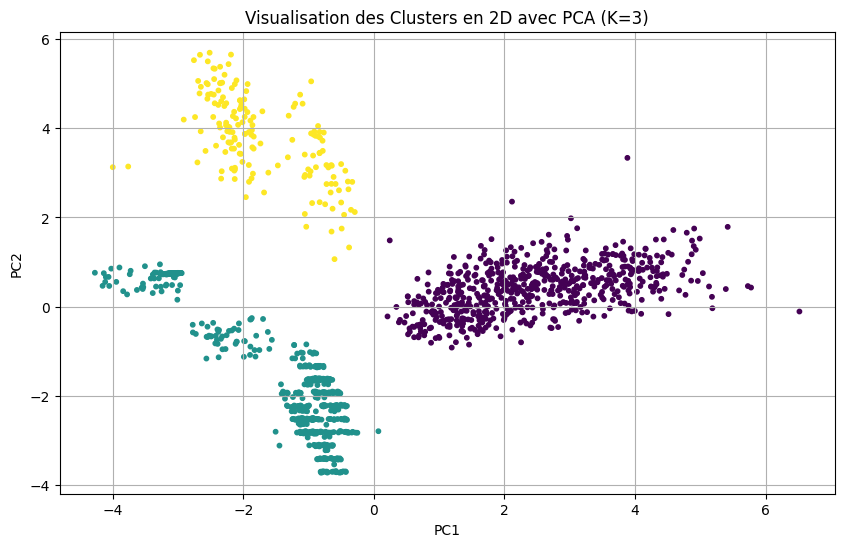

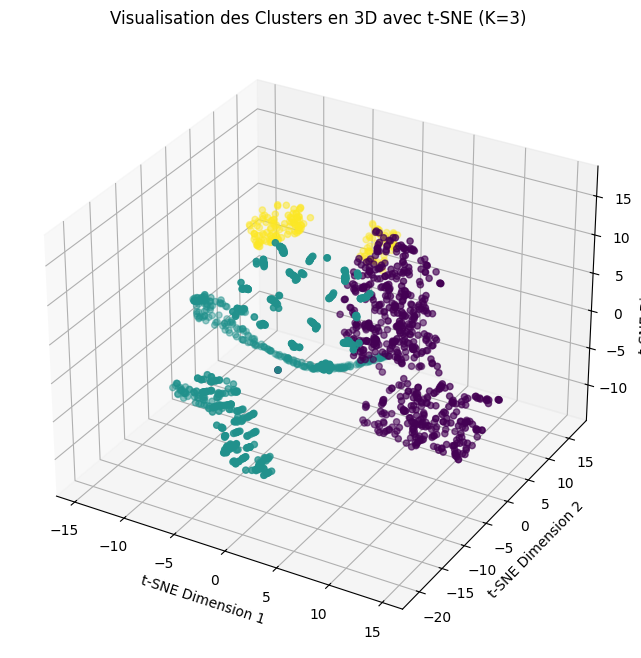

In [28]:
print("\n--- Visualisation des Clusters (PCA 2D et t-SNE 3D) ---")

# --- PCA 2D ---
os.makedirs("plots_pca", exist_ok=True)
pca = PCA(n_components=2)
pca_data = pca.fit_transform(df_scaled)

plt.figure(figsize=(10, 6))
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=cluster_labels, s=10)
plt.title(f"Visualisation des Clusters en 2D avec PCA (K={K_OPTIMAL})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.savefig("plots_pca/visualisation_pca_clusters.png")
plt.show() # Affichage
plt.close()

# --- t-SNE 3D ---
os.makedirs("plots_tsne", exist_ok=True)
# Remarque : t-SNE peut prendre du temps sur des jeux de données volumineux
tsne = TSNE(n_components=3, random_state=42, n_jobs=-1, perplexity=30, init='pca', learning_rate='auto') 
tsne_data_3d = tsne.fit_transform(df_scaled)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(tsne_data_3d[:, 0], 
                     tsne_data_3d[:, 1], 
                     tsne_data_3d[:, 2], 
                     c=cluster_labels, 
                     cmap='viridis', 
                     s=20)

legend1 = ax.legend(*scatter.legend_elements(), 
                     title="Clusters",
                     bbox_to_anchor=(1.05, 1), loc='upper left')
ax.add_artist(legend1)

ax.set_title(f"Visualisation des Clusters en 3D avec t-SNE (K={K_OPTIMAL})")
ax.set_xlabel("t-SNE Dimension 1")
ax.set_ylabel("t-SNE Dimension 2")
ax.set_zlabel("t-SNE Dimension 3") 

output_filename = f"plots_tsne/visualisation_tsne_3d_clusters_k{K_OPTIMAL}.png"
plt.savefig(output_filename)
plt.show() # Affichage
plt.close()